<font size="+3">Auto-encodeurs</font>

---

L'objectif de ce TP est de manipuler des auto-encodeurs sur un exemple simple : la base de données MNIST. L'idée est de pouvoir visualiser les concepts vus en cours, et notamment d'illustrer la notion d'espace latent.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import img_to_array
from keras import backend as K

import tensorflow
tensorflow.__version__

2024-10-02 09:44:09.138166: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-02 09:44:09.176453: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-02 09:44:09.446380: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 09:44:09.446419: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 09:44:09.447241: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

'2.14.0'

# Données MNIST

In [2]:
from keras.datasets import mnist

# Chargement et normalisation (entre 0 et 1) des données de la base de données MNIST
(x_train, _), (x_test, _) = mnist.load_data()

Comme vu dans les précédents TPs, la stabilité des algorithmes est améliorée par la normalisation des données.

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


Le code suivant affiche des exemples d'images.

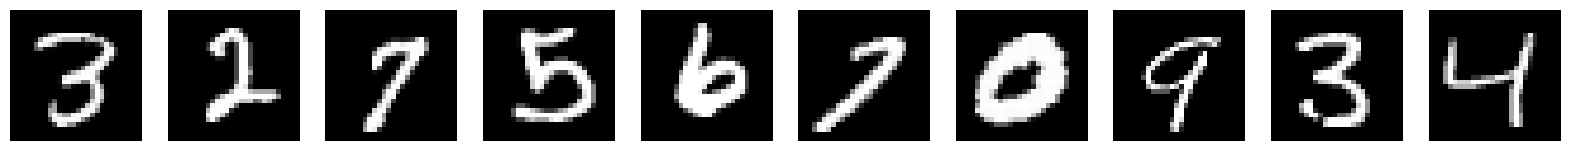

In [4]:
n = 10
idx = [random.randint(0, x_train.shape[0]) for _ in range(0, n)]

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train[idx[i]].reshape(28, 28))
    plt.gray()
    ax.grid(False)
    plt.axis('off')
plt.show()

# Un premier auto-encodeur **très** simple

Nous allons d'abord construire une architecture très simple où :

* L'**encodeur** : est une couche dense composée de 32 neurones (la dimension de la variable latente) avec une fonction d'activation $\texttt{reLu}$ :
$$\texttt{reLu}(x) = max(0,x) \,,$$

* Le **décodeur** : est une couche dense composée de $784=28\times28$ neurones (la dimension d'entrée) avec une fonction d'activation sigmoïde :
$$\sigma(x) = \frac{1}{1+\text{e}^x} \,.$$

On commence par vectoriser les images d'entrées.

In [5]:
# Vectorisation des images d'entrée en vecteurs de dimmension 784
x_train = np.reshape(x_train, (len(x_train), 784))
x_test = np.reshape(x_test, (len(x_test), 784))

print(x_train.shape)
print(x_test.shape)

n_latent = 32
n_input = 784

(60000, 784)
(10000, 784)


**Exercice** : écrire le modèle simple décrit ci-dessus dans `Keras`.

In [8]:
# Création du modèle
simple_autoencoder = Sequential(name='autoencoder')
simple_autoencoder.add(Input(shape=(n_input,)))
simple_autoencoder.add(Dense(n_latent, activation='relu', name='encoder_layer'))
simple_autoencoder.add(Dense(n_input, activation='sigmoid', name='decoder_layer'))

simple_autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_layer (Dense)       (None, 32)                25120     
                                                                 
 decoder_layer (Dense)       (None, 784)               25872     
                                                                 
Total params: 50992 (199.19 KB)
Trainable params: 50992 (199.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# %load solutions/simple_autoencoder.py

Nous pouvons à présent entraîner le modèle. Notez que _la variable cible est l'image originale._

In [10]:
simple_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

simple_autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
469/469 [==============================] - 6s 10ms/step - loss: 0.2265 - val_loss: 0.1578
Epoch 2/50
469/469 [==============================] - 5s 11ms/step - loss: 0.1409 - val_loss: 0.1252
Epoch 3/50
469/469 [==============================] - 5s 10ms/step - loss: 0.1182 - val_loss: 0.1097
Epoch 4/50
469/469 [==============================] - 5s 11ms/step - loss: 0.1067 - val_loss: 0.1016
Epoch 5/50
469/469 [==============================] - 5s 10ms/step - loss: 0.1006 - val_loss: 0.0972
Epoch 6/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0973 - val_loss: 0.0948
Epoch 7/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0956 - val_loss: 0.0938
Epoch 8/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0948 - val_loss: 0.0932
Epoch 9/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0943 - val_loss: 0.0929
Epoch 10/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0940 - val_loss: 0

**Remarque** : Nous avons utilisé ici l'entropie croisée binaire comme fonction de perte en suivant l'article fondateur [[Kingma & Welling, 2014]](https://arxiv.org/pdf/1312.6114.pdf). Ce choix est ici licite du fait de la fonction d'activation _sigmoïde_.

**Exercice** : Vérifier la performance du modèle en visualisant des exemples d'images de la base de test et de leur reconstruction.

In [24]:
## A COMPLETER ##

def vizualise (x_test,imgs,sz=(28,28)) :
    # sz désigne la taille des images 'imgs' avant reshape pour l'apprentissage
    n = 10
    idx = [random.randint(0, x_test.shape[0]) for _ in range(0, n)]

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[idx[i]].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i+1 + n)
        plt.imshow(imgs[idx[i]].reshape(sz))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [12]:
# %load solutions/vizualise.py

313/313 [==============================] - 1s 3ms/step


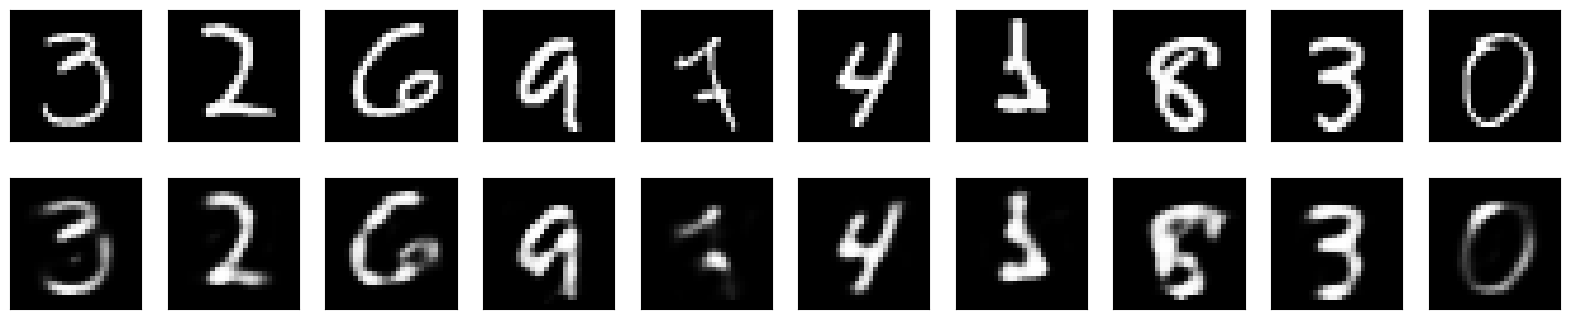

In [13]:
decoded_imgs = simple_autoencoder.predict(x_test)
vizualise (x_test,decoded_imgs)

# Un auto-encodeur plus réaliste

Afin de pouvoir accéder facilement à l'espace latent, on préfère généralement définir trois modèle distinct : un encodeur, un décodeur et l'auto-encodeur comme concaténation des deux.

Le code ci-après permet cette décomposition. On au profite pour complexifier _légèrement_ l'architecture. 

In [14]:
n_latent = 32
n_input = 784

In [15]:
# Dimension de l'entrée
input_img = Input(shape=(n_input,))

# Définition de l'encoder
x = Dense(128, activation='relu')(input_img)
encoded = Dense(n_latent, activation='linear')(x)
encoder = Model(input_img, encoded, name = "encoder")

# Définition du decoder
decoder_input = Input(shape=(n_latent,))
x = Dense(128, activation='relu')(decoder_input)
decoded = Dense(784, activation='linear')(x)
decoder = Model(decoder_input, decoded, name = "decoder")

# Construction de l'auto-encodeur
encoded = encoder(input_img)
decoded = decoder(encoded)
autoencoder = Model(input_img, decoded, name = "autoencoder")

print(autoencoder.summary())
print(" ")
print(encoder.summary())
print(" ")
print(decoder.summary())

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 32)                104608    
                                                                 
 decoder (Functional)        (None, 784)               105360    
                                                                 
Total params: 209968 (820.19 KB)
Trainable params: 209968 (820.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
 
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                         

In [16]:
autoencoder.compile(optimizer='Adam', loss='mse')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
469/469 [==============================] - 8s 15ms/step - loss: 0.0295 - val_loss: 0.0182
Epoch 2/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0178 - val_loss: 0.0168
Epoch 3/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0170 - val_loss: 0.0162
Epoch 4/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0164 - val_loss: 0.0157
Epoch 5/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0160 - val_loss: 0.0153
Epoch 6/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0156 - val_loss: 0.0150
Epoch 7/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0152 - val_loss: 0.0147
Epoch 8/50
469/469 [==============================] - 5s 10ms/step - loss: 0.0148 - val_loss: 0.0143
Epoch 9/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0144 - val_loss: 0.0139
Epoch 10/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0141 - val_loss

313/313 [==============================] - 1s 3ms/step


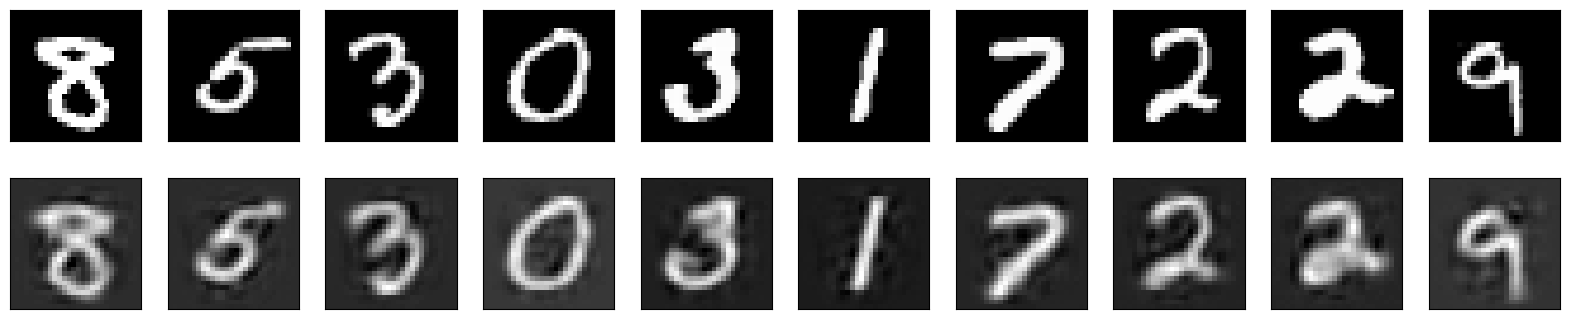

In [17]:
decoded_imgs = autoencoder.predict(x_test)
vizualise(x_test,decoded_imgs)

**Exercice** : Alors qu'on a complexifié le modèle, on obtient des résultats moins probants. À votre avis, à quoi cela peut-il être dû ? 
En vous aidant du premier modèle proposé, proposez une amélioration permettant d'obtenir de meilleurs résultats.

In [18]:
## A COMPLETER ##

def build_autoencoder(n_latent = 32):
    # Dimension de l'entrée
    input_img = Input(shape=(n_input,))

    # Définition de l'encoder
    x = Dense(128, activation='relu')(input_img)
    encoded = Dense(n_latent, activation='linear')(x)
    encoder = Model(input_img, encoded, name = "encoder")

    # Définition du decoder
    decoder_input = Input(shape=(n_latent,))
    x = Dense(128, activation='relu')(decoder_input)
    decoded = Dense(784, activation='sigmoid')(x)
    decoder = Model(decoder_input, decoded, name = "decoder")

    # Construction de l'auto-encodeur
    encoded = encoder(input_img)
    decoded = decoder(encoded)
    autoencoder = Model(input_img, decoded, name = "autoencoder")

    return autoencoder, encoder, decoder

In [19]:
# %load solutions/build_autoencoder.py

In [20]:
autoencoder, encoder, decoder = build_autoencoder(n_latent)
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
  epochs=50,
  batch_size=128,
  shuffle=True,
  validation_data=(x_test, x_test))

Epoch 1/50
469/469 [==============================] - 8s 15ms/step - loss: 0.1810 - val_loss: 0.1200
Epoch 2/50
469/469 [==============================] - 7s 15ms/step - loss: 0.1096 - val_loss: 0.1014
Epoch 3/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0989 - val_loss: 0.0947
Epoch 4/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0939 - val_loss: 0.0911
Epoch 5/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0911 - val_loss: 0.0888
Epoch 6/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0893 - val_loss: 0.0874
Epoch 7/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0879 - val_loss: 0.0863
Epoch 8/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0869 - val_loss: 0.0856
Epoch 9/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0860 - val_loss: 0.0849
Epoch 10/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0853 - val_lo

313/313 [==============================] - 1s 3ms/step


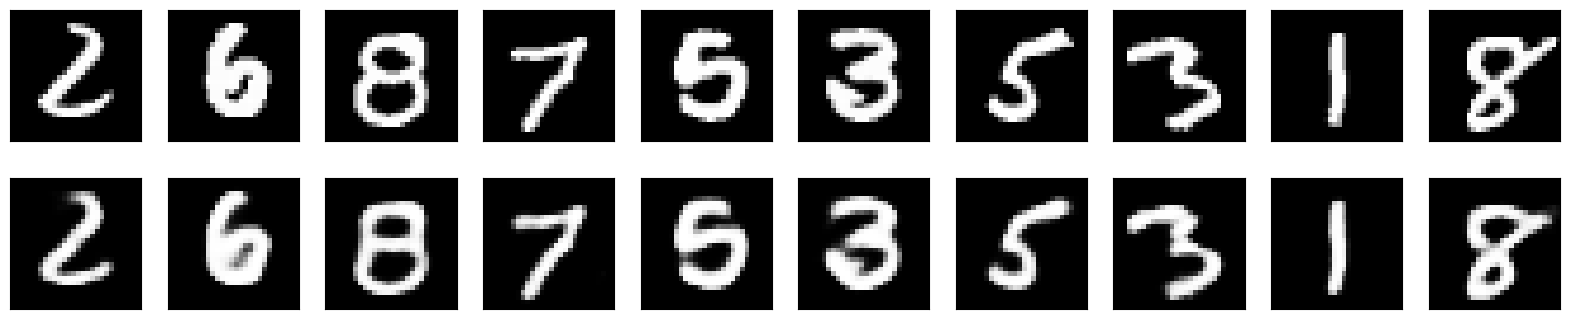

In [21]:
decoded_imgs = autoencoder.predict(x_test)
vizualise(x_test,decoded_imgs)

**Remarque** : La décomposition encodeur/décodeur dans la définition de l'auto-encodeur permet de visualiser facilement l'espace latent.

In [22]:
encoded_imgs = encoder.predict(x_test)
encoded_imgs.shape

313/313 [==============================] - 1s 2ms/step


(10000, 32)

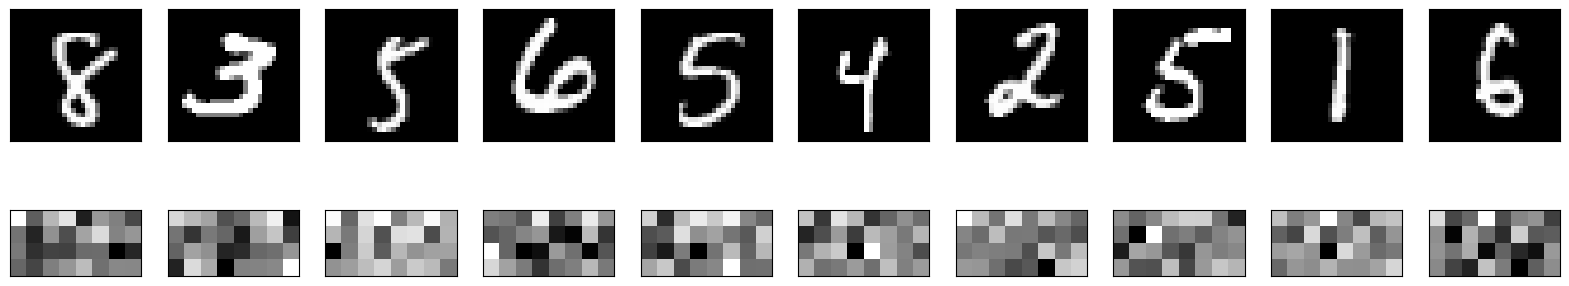

In [25]:
vizualise(x_test,encoded_imgs,sz=(4,8))

**Exercice** : Vérifier que vous obtenez les résultats en décodant les représentations latentes qu'en codant-décodant les données d'entraînement.

313/313 [==============================] - 1s 2ms/step


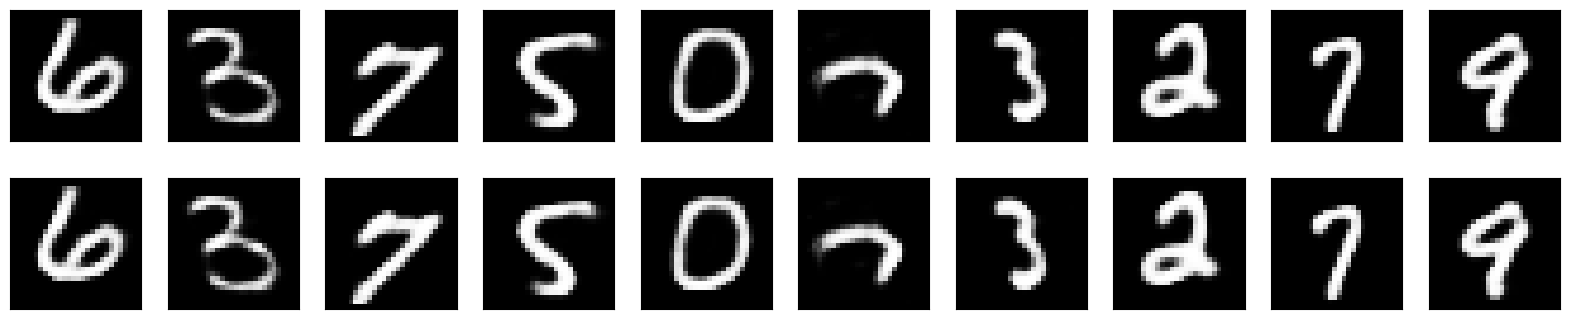

In [26]:
autoencoded_imgs = autoencoder.predict(x_test)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

vizualise(autoencoded_imgs,decoded_imgs)

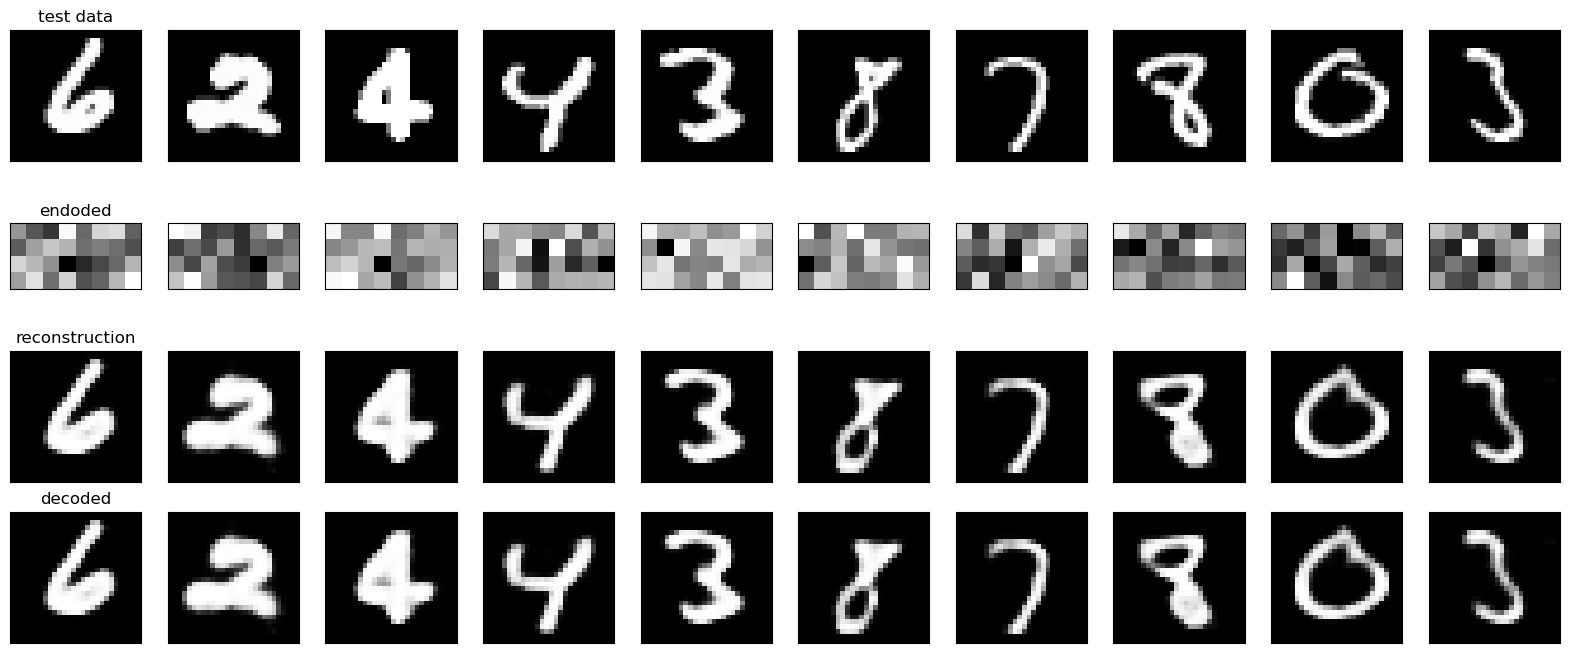

In [27]:
n = 10
idx = [random.randint(0, x_test.shape[0]) for _ in range(0, n)]

plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i+1)
    plt.imshow(x_test[idx[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded
    ax = plt.subplot(4, n, i+1 + n)
    plt.imshow(encoded_imgs[idx[i]].reshape(4,8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction through auto-encoder
    ax = plt.subplot(4, n, i+1 + 2*n)
    plt.imshow(autoencoded_imgs[idx[i]].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display decoded
    ax = plt.subplot(4, n, i+1 + 3*n)
    plt.imshow(decoded_imgs[idx[i]].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

title = ['test data','endoded','reconstruction','decoded']
for i in range(4) :  
    ax = plt.subplot(4,n,1+i*n)
    plt.title(title[i])

plt.show()

## Influence de la dimension de l'espace latent

Avec la dimension d'espace latent qui vous est fournie, on observe une (relativement) faible erreur de reconstruction. On souhaite étudier l'influence de la dimension de l'espace latent sur l'erreur de reconstruction.

**Exercice** : Tracez une _courbe_ (avec seulement quelques points) qui montre l'évolution de l'erreur de reconstruction en fonction de la dimension de l'espace latent. Quelle est la dimension minimale de l'espace latent qui permet encore d'observer une reconstruction raisonnable des données (avec le réseau qui vous est fourni) ?

Dimension espace latent : 10
Epoch 1/50
469/469 [==============================] - 8s 14ms/step - loss: 0.1990 - val_loss: 0.1463
Epoch 2/50
469/469 [==============================] - 7s 15ms/step - loss: 0.1402 - val_loss: 0.1337
Epoch 3/50
469/469 [==============================] - 7s 15ms/step - loss: 0.1321 - val_loss: 0.1282
Epoch 4/50
469/469 [==============================] - 7s 14ms/step - loss: 0.1278 - val_loss: 0.1250
Epoch 5/50
469/469 [==============================] - 7s 14ms/step - loss: 0.1250 - val_loss: 0.1228
Epoch 6/50
469/469 [==============================] - 7s 14ms/step - loss: 0.1229 - val_loss: 0.1208
Epoch 7/50
469/469 [==============================] - 7s 15ms/step - loss: 0.1212 - val_loss: 0.1192
Epoch 8/50
469/469 [==============================] - 7s 15ms/step - loss: 0.1198 - val_loss: 0.1181
Epoch 9/50
469/469 [==============================] - 7s 15ms/step - loss: 0.1187 - val_loss: 0.1171
Epoch 10/50
469/469 [==============================] - 7s 15ms

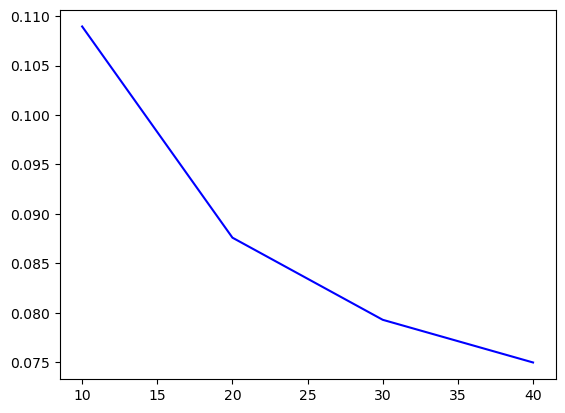

In [28]:
## A COMPLETER ##

vect_latent = []
vect_reconstruction_loss = []

for n_latent in range(10, 50, 10):
    print("Dimension espace latent : "+str(n_latent))
    autoencoder, encoder, decoder = build_autoencoder(n_latent)
    autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

    autoencoder.fit(x_train, x_train,
                  epochs=50,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(x_test, x_test))

    loss = autoencoder.evaluate(x_test, x_test)
    vect_latent.append(n_latent)
    vect_reconstruction_loss.append(loss)
    print(" ")

# --- #

plt.plot(vect_latent, vect_reconstruction_loss, 'b')
plt.show()

In [ ]:
# %load dim_latent.py

**Exercice (pour aller plus loin)** : Pour diminuer encore plus la dimension de l'espace latent, il est nécessaire d'augmenter la capacité des réseaux encodeur et décodeur. Cherchez à nouveau la dimension minimale de l'espace latent qui permet d'observer une bonne reconstruction des données, mais en augmentant à l'envi la capacité de votre auto-encodeur.

# Auto-encodeurs éparses

In [ ]:
from tensorflow.keras import regularizers

Dans l'exemple précédent, l'autoencodeur n'est contraint que par la taille de la couche cachée.

Dans la figure suivante, vous pouvez voir la distribution du nombre de variables latentes fixées à zéro pour les 10.000 images de test.

In [ ]:
ax = plt.subplot(1,1,1)
plt.hist(np.sum(encoded_imgs==0,axis=1), width=0.9, bins=np.arange(-0.5,10.5,1))
ax.set_xticks(np.arange(10))
plt.show()

Autrement dit, notre espace latent est très plein... On désire obtenir une représentations latente _creuse_. Pour cela, nous allons ajouter à notre auto-encodeur une contrainte de parcimonie.

**Exercice** : En modifiant l'auto-encodeur précédent, réaliser un encodage parcimonieux.

In [ ]:
## A COMPLETER ##

n_latent = 32
l = 10e-4

[...]

In [5]:
# %load solutions/build_sparse_autoencoder.py

In [ ]:
sparse_autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

sparse_autoencoder.fit(x_train, x_train,
  epochs=50,
  batch_size=256,
  #shuffle=True,
  validation_data=(x_test, x_test))

**Exercice** : Vérifiez que les images encodées par l'auto-codeur parcimonieux sont effectivement plus creuses que celles obtenues par l'auto-codeur classique.

In [ ]:
## A COMPLETER ##

[...]

In [ ]:
# %load solutions/sparse_autoencoder.py

**Exercice** : Comparez les images reconstruites obtenues par le premier modèle et le modèle parcimonieux.

In [ ]:
## A COMPLETER ##

sparse_encoded_imgs = sparse_encoder.predict(x_test)
sparse_decoded_imgs = sparse_decoder.predict(sparse_encoded_imgs)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# --- #

n = 10
idx = [random.randint(0, x_test.shape[0]) for _ in range(0, n)]

plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(5, n, i+1)
    plt.imshow(x_test[idx[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded
    ax = plt.subplot(5, n, i+1 + n)
    plt.imshow(encoded_imgs[idx[i]].reshape(4,8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display sparse_encoded
    ax = plt.subplot(5, n, i+1 + 2*n)
    plt.imshow(sparse_encoded_imgs[idx[i]].reshape(4,8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display decoded
    ax = plt.subplot(5, n, i+1 + 3*n)
    plt.imshow(decoded_imgs[idx[i]].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display sparse_decoded
    ax = plt.subplot(5, n, i+1 + 4*n)
    plt.imshow(sparse_decoded_imgs[idx[i]].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

title = ['test data','encoded','sparse encoded','decoded','sparse decoded']
for i in range(5) :  
    ax = plt.subplot(5,n,1+i*n)
    plt.title(title[i])

#plt.tight_layout()
plt.show()

In [ ]:
# %load solutions/sparse_autoencoder_compare.py

# Auto-encodeurs convolutionnels

Dans les parties précédentes, nous avons vu des auto-codeurs très simples où les parties encodeur et décodeur sont des perceptrons. Comme vu en cours, ils peuvent tous deux être composés de plus de couches et de différents types de couches.

En particulier, les couches convolutionnelles sont les meilleures couches à utiliser lorsqu'il s'agit d'images.

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D

**Exercice** : Implémentez un auto-codeur convolutif avec l'architecture suivante : 

`Encodeur` :
* Une couche de convolution 2D, 16 filtres de taille 3x3
* Une couche de maxpooling 2D avec des filtres de taille 2x2
* Une couche de convolution 2D, 8 filtres de taille 3x3
* Une couche de maxpooling 2D avec des filtres de taille 2x2
* Une couche de convolution 2D, 8 filtres de taille 3x3
* Une couche de maxpooling 2D avec des filtres de taille 2x2

`Décodeur` :
* Une couche de convolution 2D, 8 filtres de taille 3x3
* Une couche de suréchantillonnage (upsampling) 2D avec des filtres de taille 2x2
* Une couche de convolution 2D, 8 filtres de taille 3x3
* Une couche de suréchantillonnage 2D avec des filtres de taille 2x2
* Une couche de convolution 2D, 16 filtres de taille 3x3
* Une couche de suréchantillonnage 2D avec des filtres de taille 2x2
* Une couche de convolution 2D, 1 filtre de taille 3x3, avec activation $\texttt{sigmoid}$.


_Tous les rembourrages (padding) sont des rembourrages $\texttt{same}$ et toutes les fonctions d'activation des couches de convolution, sauf la dernière, sont des $\texttt{reLu}$._

In [ ]:
## A COMPLETER ##

[...]

Vous devez obtenir le summary suivant :

```
Model: "conv_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 conv_encoder (Sequential)   (None, 4, 4, 8)           1904      
                                                                 
 conv_decoder (Sequential)   (None, 28, 28, 1)         2481      
                                                                 
=================================================================
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________

```

In [ ]:
# %load solutions/build_conv_autoencoder.py

In [ ]:
conv_autoencoder = build_conv_autoencoder()
conv_autoencoder.summary()

In [ ]:
# x_train = np.expand_dims(x_train, axis=-1)
# x_test = np.expand_dims(x_test, axis=-1)

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

print(x_train.shape)
print(x_test.shape)

In [ ]:
conv_autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

conv_autoencoder.fit(x_train, x_train,
  epochs=10,
  batch_size=256,
  validation_data=(x_test, x_test))

In [ ]:
conv_autoencoder.evaluate(x_train, x_train)

In [ ]:
conv_decoded_imgs = conv_autoencoder.predict(x_test)
vizualise(x_test,conv_decoded_imgs)

# Application au débruitage

Nous savons maintenant comment construire un auto-encodeur convolutionnel. Nous allons maintenant voir comment il peut être utilisé pour résoudre un problème de débruitage d'image.

Nous créons d'abord de fausses données bruitées à partir des données MNIST.

In [ ]:
# Add random noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

# Value greater than 1 are set to 1 and value lower than 0 are set to zero
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Observons le bruit que nous avons créé.

In [ ]:
vizualise(x_test,x_test_noisy)

**Exercice** : En utilisant l'auto-encodeur défini précédemment, réaliser le débruitage de ces images et visualiser l'effet du débruitage.

In [ ]:
## A COMPLETER ##

[...]

In [ ]:
# %load solutions/denoising.py

In [ ]:
# %load solutions/denoising_plot.py

---
# Pour aller plus loin

**Exercice 1** : Écrivez une fonction qui, étant donnés deux données de votre espace de test $I_1$ et $I_2$, réalise l'interpolation (avec, par exemple, 10 étapes) entre la représentation latente ($z_1 = $encoder($I_1$) et $z_2 = $encoder($I_2$)) de ces deux données, et génère les images $I_i$ correspondant aux représentations latentes intermédiaires $z_i$. En pseudo python, cela donne : 

```python
for i in range(10):
    z_i = z1 + i*(z2-z1)/10
    I_i = decoder(z_i)
```
Testez cette fonction avec un auto-encodeur avec une faible erreur de reconstruction, sur deux données présentant le même chiffre écrit différemment, puis deux chiffres différents.

---
**Exercice 2 (Visage)** : Le code fourni dans la suite permet de télécharger et de préparer une [base de données de visages](http://vis-www.cs.umass.edu/lfw/). 

ATTENTION : ici les images sont couleur et comportent 3 canaux (contrairement aux images de MNIST, qui n'en comptent qu'un). 

Par analogie avec l'exercice précédent, on pourrait grâce à la représentation latente apprise par un auto-encodeur, réaliser un morphing entre deux visages. Essayez d'abord d'entraîner un auto-encodeur à obtenir une erreur de reconstruction faible. Qu'observe-t-on ?

In [ ]:
import pandas as pd
import tarfile, tqdm, cv2, os
from sklearn.model_selection import train_test_split
import numpy as np


# Télécharger les données de la base de données "Labelled Faces in the Wild"
!wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
  
ATTRS_NAME = "lfw_attributes.txt"
IMAGES_NAME = "lfw-deepfunneled.tgz"
RAW_IMAGES_NAME = "lfw.tgz"


def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def load_lfw_dataset(use_raw=False,
                     dx=80, dy=80,
                     dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    # tqdm in used to show progress bar while reading the data in a notebook here, you can change
    # tqdm_notebook to use it outside a notebook
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs


# Prépare le dataset et le charge dans la variable X
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

# Normalise les images
X = X/255

# Sépare les images en données d'entraînement et de test
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)